# Audio Capture & Augmentation
#### Author: Jeromey Schwartz
#### *Audio capture code (indicated with *) supplied by Dr. Jeremy Holleman UNC-Charlotte 

### Purpose:
This will record an audio sample 1 second long at a sampling rate of 16kHz, the samples can then be augmented by adding noise, pitch shifting, or time shifting 

### Program Flow:
1. Load libraries/setup code 
2. Save a number of audio samples 
3. Save ambient noise samples 
4. Noise shift 
5. Time shift 
6. Pitch shift 
7. Save samples names in validation document 

#### Import libraries

In [1]:
import tensorflow as tf
from tensorflow.lite.experimental.microfrontend.python.ops import audio_microfrontend_op as frontend_op
import numpy as np
import time
from scipy.io import wavfile
import random
import sys
import io
import os
import pathlib
import glob
from datetime import datetime as dt
from numpy import log as ln
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt
from scipy.io.wavfile import write
import IPython
import IPython.display as ipd
import tensorflow as tf
%matplotlib inline
import pyaudio
from queue import Queue
from threading import Thread
import math
import time
import librosa

#### Set Parameters*

In [61]:
i16min            = -32768
i16max            = 32767
fsamp             = 16000
wave_length_ms    = 1000
wave_length_samps = 16000
window_size_ms    = 60
window_step_ms    = 40
num_filters       = 32
use_microfrontend = True
keyword        = 'internet'
spectrogram_shape = (64, 24, 32, 1)

chunk_duration = 0.25 # Each read length in seconds from mic.
fs = 16000 # sampling rate for mic
sample_rate = 16000 # sampling rate for mic
chunk_samples = int(fs * chunk_duration) # Each read length in number of samples.

# Each model input data duration in seconds, need to be an integer numbers of chunk_duration
feed_duration = 1.0
feed_samples = int(fs * feed_duration)

assert feed_duration/chunk_duration == int(feed_duration/chunk_duration)

#### Create keyword & noise folders*

In [62]:
# Ensure the parent directory and folder paths are correctly defined
parent_dir = os.getcwd()  # gets current directory
folder_pre = "Augmented_"
folder = folder_pre + keyword  # name of directory
dir = os.path.join(parent_dir, folder)
noise_dir = os.path.join(parent_dir, "noise")

# Check and create the directories if they don't exist
if not os.path.exists(dir):
    os.mkdir(dir)  # creating folder
    print(f"Directory '{folder}' created")

if not os.path.exists(noise_dir):
    os.mkdir(noise_dir)  # creating folder
    print("Directory 'noise' created")

keyword_directory = dir + '\\'
print(parent_dir)
print(folder)

Directory 'Augmented_internet' created
c:\Users\Matt\OneDrive\Documents\Github\Github-IOT-Project-2\training\preprocessing
Augmented_internet


# Get Custom Data

#### Run this code to get in an audio sample*

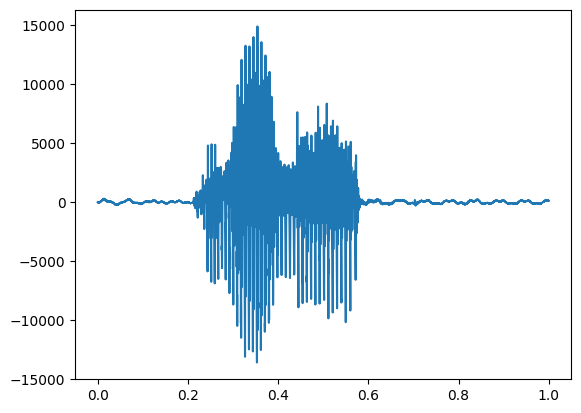

In [72]:
# Queue to communiate between the audio callback and main thread
q = Queue()
run = True
silence_threshold = 100
# Run the demo for a timeout seconds
timeout = time.time() + 1 
# Data buffer for the input wavform
data = np.zeros(feed_samples, dtype='int16')

def callback(in_data, frame_count, time_info, status):
    global run, timeout, data, silence_threshold    
    if time.time() > timeout:
        run = False        
    data0 = np.frombuffer(in_data, dtype='int16')
    data = np.append(data,data0)    
    if len(data) > feed_samples:
        data = data[-feed_samples:]
        # Process data async by sending a queue.
        q.put(data)
    return (in_data, pyaudio.paContinue)

stream = pyaudio.PyAudio().open(
    format=pyaudio.paInt16,
    channels=1,
    rate=fs,
    input=True,
    frames_per_buffer=chunk_samples,
    input_device_index=0,
    stream_callback=callback)
stream.start_stream()
try:
    while run:        
        data = q.get()
except (KeyboardInterrupt, SystemExit):
    stream.stop_stream()
    stream.close()
    timeout = time.time()
    run = False      
stream.stop_stream()
stream.close()

sample_rate = fs


#Displaying wave file data
plt.plot(np.arange(1*fs)/fs, data)
plt.show()
ipd.Audio(data, rate=fs)

#### If the Sample looks good run cell below to save it 

In [73]:
# #saving the wave file to training_data
date_str = dt.now().strftime("%H%M%S").lower()
current_name = f"{keyword_directory}{keyword}_{date_str}.wav"
write(current_name, sample_rate, data)
print("Audio sample saved")

Audio sample saved


#### Noise
* To get noise data run "get data" loop again to get ambient room
* Save here
* Get ~3 samples total

In [28]:
# #saving the wave file to training_data
date_str = dt.now().strftime("%H%M%S").lower()
current_name = f"{parent_dir}/noise/noise_{date_str}.wav"
write(current_name, sample_rate, data)
print("Audio sample saved as noise")

Audio sample saved as noise


# Audio Augmentation- Noise
    * This will create copies of sample audio and add pre-recorded noise. 
    * The amplitude of the noise depends on *noise_count*
    * Audio samples and visualizations are created to show noise augmentation

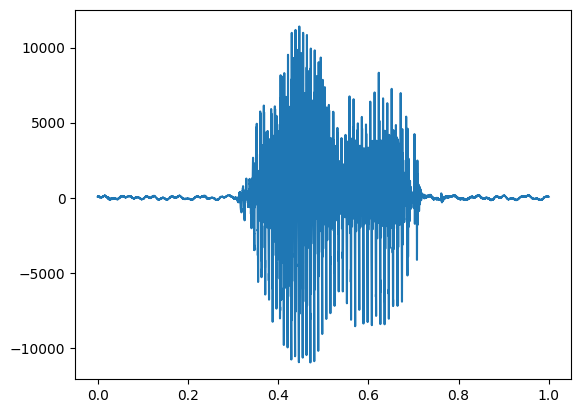

In [74]:
#Selecting augmentation folder & files
data_dir = dir
filenames = tf.io.gfile.glob(str(data_dir) + '/*.wav')

#Testing if audio data imported correctly
test_wav=filenames[0]
fs, test_wav = wavfile.read(test_wav)
plt.plot(np.arange(1*fs)/fs, test_wav)
plt.show()
ipd.Audio(test_wav, rate=fs)

In [75]:
#Loading noise samples
noise_dir = parent_dir+'\\noise'
noise_samples = tf.io.gfile.glob(str(noise_dir) + '/*.wav')
print("Noise Samples:", len(noise_samples))

Noise Samples: 3


#### Set Augment count

In [78]:
#noise_count will deteremine how many augmentations will be created
    #noise_count=1 will be a copy with noise augmentation * 0
    #noise_count=2 will be noise_count=1 plus a copy with noise augmentation * 1
    #noise_count=2 will be noise_count=2 plus a copy with noise augmentation * 2  
    #and so on 

noise_count=40
print("This will expand the current", len(filenames), "files by creating an addtional",len(filenames)*len(noise_samples)*noise_count, "noise augmented files, to give a total of",len(filenames)*len(noise_samples)*(noise_count)+len(filenames),"files")

This will expand the current 3 files by creating an addtional 360 noise augmented files, to give a total of 363 files


#### Creating Noise Augmentation

In [79]:
#dict holds samples for plotting
noise_dict={}
for index in range(len(filenames)):
    test_wav=filenames[index]
    fs, test_wav = wavfile.read(test_wav)
    if (len(test_wav) < fs):
        padding=fs-len(test_wav)
        extra_padding=np.zeros(padding).astype(np.int16) #array of empty audio to pad with
        test_wav=np.concatenate((test_wav,extra_padding),axis=0).astype(np.int16)
    noise_dict[0]=test_wav.astype(np.int16)
    for i in range(len(noise_samples)):
        noise=noise_samples[i]
        fs, noise = wavfile.read(noise)
        for j in range(noise_count):
            noise_multiplier=round(max(test_wav)*(j/2000))
            noise_lvl=noise*noise_multiplier
            test_wave_with_noise=np.add(test_wav,noise_lvl)
            current_name = str(keyword_directory) + str(keyword)+f"_Sample{index}_Noise{i}_Multiplier{j}.wav"
            write(current_name, fs, test_wave_with_noise)
            noise_dict[j+1]=test_wave_with_noise.astype(np.int16)
            noise_dict[j+5]=noise_lvl.astype(np.int16)

#### Plotting noise augmenation

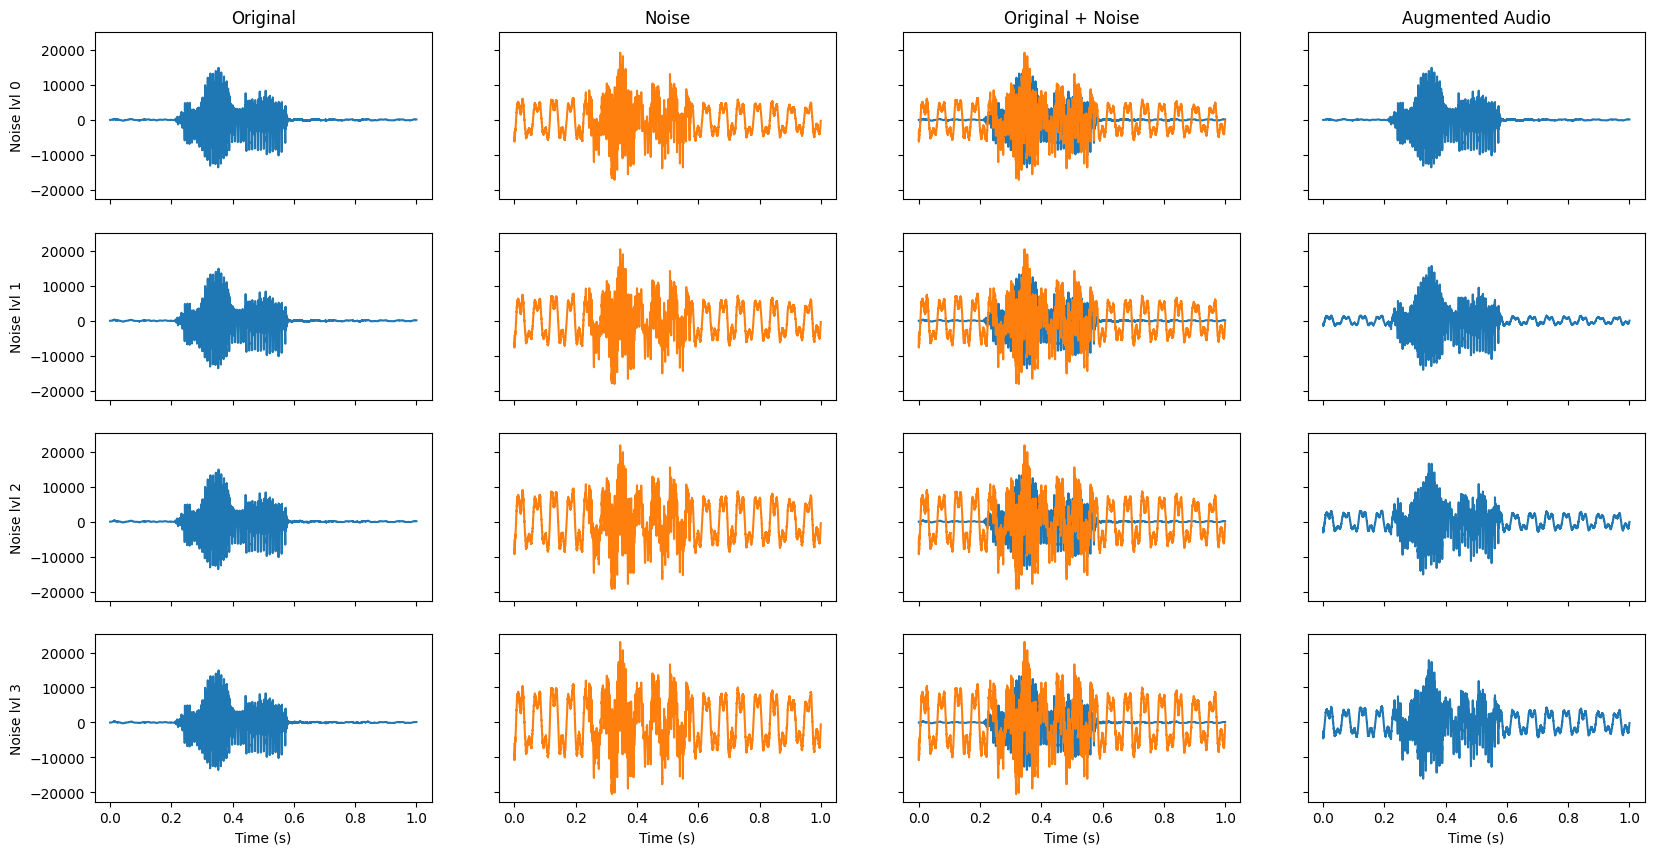

In [80]:
#Only plots up to noise lvl 3
fig, axs = plt.subplots(4, 4,figsize=(20,10), sharex=True,sharey=True)
axs[0,0].plot(np.arange(1*fs)/fs, noise_dict[0])
axs[0,1].plot(np.arange(1*fs)/fs, noise_dict[5], 'tab:orange')
axs[0,2].plot(np.arange(1*fs)/fs, noise_dict[0])
axs[0,2].plot(np.arange(1*fs)/fs, noise_dict[5])
axs[0,3].plot(np.arange(1*fs)/fs, noise_dict[1])

axs[0, 0].set_title("Original")
axs[0, 1].set_title("Noise")
axs[0, 2].set_title("Original + Noise")
axs[0, 3].set_title("Augmented Audio")

axs[0, 0].set(xlabel='Time (s)', ylabel='Noise lvl 0')
axs[1, 0].set(xlabel='Time (s)', ylabel='Noise lvl 1')
axs[2, 0].set(xlabel='Time (s)', ylabel='Noise lvl 2')
axs[3, 0].set(xlabel='Time (s)', ylabel='Noise lvl 3')

axs[1,0].plot(np.arange(1*fs)/fs, noise_dict[0])
axs[1,1].plot(np.arange(1*fs)/fs, noise_dict[6], 'tab:orange')
axs[1,2].plot(np.arange(1*fs)/fs, noise_dict[0])
axs[1,2].plot(np.arange(1*fs)/fs, noise_dict[6])
axs[1,3].plot(np.arange(1*fs)/fs, noise_dict[2])

axs[2,0].plot(np.arange(1*fs)/fs, noise_dict[0])
axs[2,1].plot(np.arange(1*fs)/fs, noise_dict[7], 'tab:orange')
axs[2,2].plot(np.arange(1*fs)/fs, noise_dict[0])
axs[2,2].plot(np.arange(1*fs)/fs, noise_dict[7])
axs[2,3].plot(np.arange(1*fs)/fs, noise_dict[3])

axs[3,0].plot(np.arange(1*fs)/fs, noise_dict[0])
axs[3,1].plot(np.arange(1*fs)/fs, noise_dict[8], 'tab:orange')
axs[3,2].plot(np.arange(1*fs)/fs, noise_dict[0])
axs[3,2].plot(np.arange(1*fs)/fs, noise_dict[8])
axs[3,3].plot(np.arange(1*fs)/fs, noise_dict[4])

for ax in axs.flat:
    ax.set(xlabel='Time (s)')

# Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in axs.flat:
    ax.label_outer()

#### Listen to noise augmenation

In [81]:
#Only samples up to noise lvl 3
from IPython.display import Audio 
from IPython.display import display

print("Noise lvl 0:")
display(Audio(noise_dict[0], rate=fs))
print("Noise lvl 1:")
display(Audio(noise_dict[2], rate=fs))
print("Noise lvl 2:")
display(Audio(noise_dict[3], rate=fs))
print("Noise lvl 3:")
display(Audio(noise_dict[4], rate=fs))

Noise lvl 0:


Noise lvl 1:


Noise lvl 2:


Noise lvl 3:


# Audio Augmentation- Time Shift
    * This will create copies of sample audio and shift them forward or backward in time in 1/8s increments 
    * The "empty space" created by the time shift is filled with artificial noise (created in cell 12)

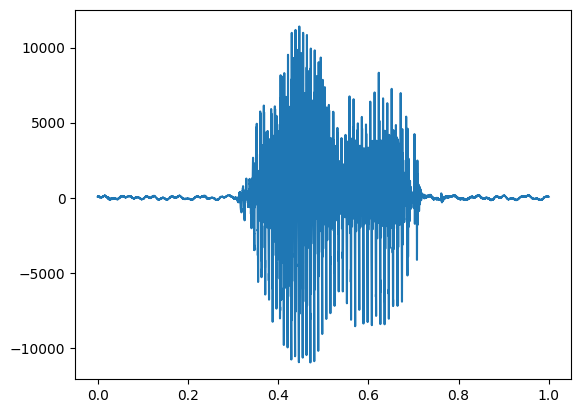

In [82]:
#Need to update filenames
data_dir = dir
filenames = tf.io.gfile.glob(str(data_dir) + '/*.wav')
#Testing if audio data imported correctly
filenames[0]
test_wav=filenames[0]
fs, test_wav = wavfile.read(test_wav)
plt.plot(np.arange(1*fs)/fs, test_wav)
plt.show()
ipd.Audio(test_wav, rate=fs)

In [83]:
#initializing variables for 1/8th second time shifts
one_eighth=int((sample_rate/8)) #16k sample rate means 2k for 1/8s
padding=one_eighth #Number of samples to pad
#zero_padding=np.zeros(padding).astype(np.int16) #array of empty audio to pad with
noise_lvl_min=-200 #about the min for quiet room when measured with get audio code above
noise_lvl_max=200 #about the max for quiet room when measured with get audio code above
noise_padding=np.random.randint(noise_lvl_min,noise_lvl_max+1,padding) #makes random noise

#### Set Augment count

In [84]:
#how many of each type of time shift is desired..in 1/8s increments
#suggest following bell curve with center being zero_shift and left_3/right_3 being the extremes

left_3=1
left_2=2
left_1=2
zero_shift=2
right_1=2
right_2=2
right_3=1

total=zero_shift+right_3+right_2+right_1+left_3+left_2+left_1

In [85]:
print("This will expand the current", len(filenames), "files by creating an addtional",len(filenames)*total, "time shifted files, to give a total of",len(filenames)*(total+1),"files")

This will expand the current 363 files by creating an addtional 4356 time shifted files, to give a total of 4719 files


#### Time Shift Augment

In [86]:
#creates dictionary to hold audio for data visualization
audio_dict={}

##This will randomize audio samples
#random_list = list(range(0, len(filenames))) #create array [1,2,3...]
#random.shuffle(random_list) #randomize the array

#This will reverse the list so the element printed in next cell shows augmentation to original sample
random_list = list(range(0, len(filenames))) #create array [1,2,3...]
random_list.reverse() #randomize the array

#runs 5x shifts audio from original to left by .5sec in 1/8s increments
for index in range(len(filenames)):
    test_wav=filenames[random_list[index]]
    fs, test_wav = wavfile.read(test_wav)
    audio_dict[0]=test_wav.astype(np.int16)#dict[0] holds original audio
    test_wav_decrease = test_wav #creating copy to be manipulated 
    test_wav_increase = test_wav #creating copy to be manipulated
    
    #shift audio to left in 1/8s increments
    for j in range(1,4):#dict 1-4 hold shifted audio (change 4 to 5 to make 1/2s shift)
        for i in range (one_eighth):
            test_wav_decrease=np.delete(test_wav_decrease,0)
        test_wav_decrease=np.concatenate((test_wav_decrease,noise_padding),axis=0).astype(np.int16)
        audio_dict[j]=test_wav_decrease.astype(np.int16)
        if (j==1):
            for p in range(left_1): #creates left_1 copys shifted left 1/8s
                current_name = str(keyword_directory) + str(keyword)+f"_Sample{index}_LShift{j}_{p}.wav"
                write(current_name, fs, test_wav_decrease)
        if (j==2):
            for p in range(left_2): #creates left_2 copys shifted left 2/8s
                current_name = str(keyword_directory) + str(keyword)+f"_Sample{index}_LShift{j}_{p}.wav"
                write(current_name, fs, test_wav_decrease)
        if (j==3):
            for p in range(left_3): #creates left_3 copy shifted left 3/8s
                current_name = str(keyword_directory) + str(keyword)+f"_Sample{index}_LShift{j}_{p}.wav"
                write(current_name, fs, test_wav_decrease)

    
    #shift audio to right in 1/8s increments
    for k in range(6,9):
        #pad zeros to front
        test_wav_increase=np.concatenate((noise_padding,test_wav_increase),axis=0)
        #delete data past 16k samples
        for d in range(sample_rate,len(test_wav_increase)):
            test_wav_increase=np.delete(test_wav_increase,sample_rate,0).astype(np.int16)
        audio_dict[k]=test_wav_increase
        if (k==6):
            for p in range(right_1): #creates right_1 copys shifted right 1/8s
                current_name = str(keyword_directory) + str(keyword)+f"_Sample{index}_RShift{k-5}_{p}.wav"
                write(current_name, fs, test_wav_decrease)
        if (k==7):
            for p in range(right_2): #creates right_2 copys shifted right 2/8s
                current_name = str(keyword_directory) + str(keyword)+f"_Sample{index}_RShift{k-5}_{p}.wav"
                write(current_name, fs, test_wav_decrease)
        if (k==8):
            for p in range(right_3): #creates right_3 copy shifted right 3/8s
                current_name = str(keyword_directory) + str(keyword)+f"_Sample{index}_RShift{k-5}_{p}.wav"
                write(current_name, fs, test_wav_decrease)
    for l in range(zero_shift):
        current_name = str(keyword_directory) + str(keyword)+f"_Sample{index}_NoShift_{l}.wav"
        write(current_name, fs, test_wav)

#### Plot time shifted audio

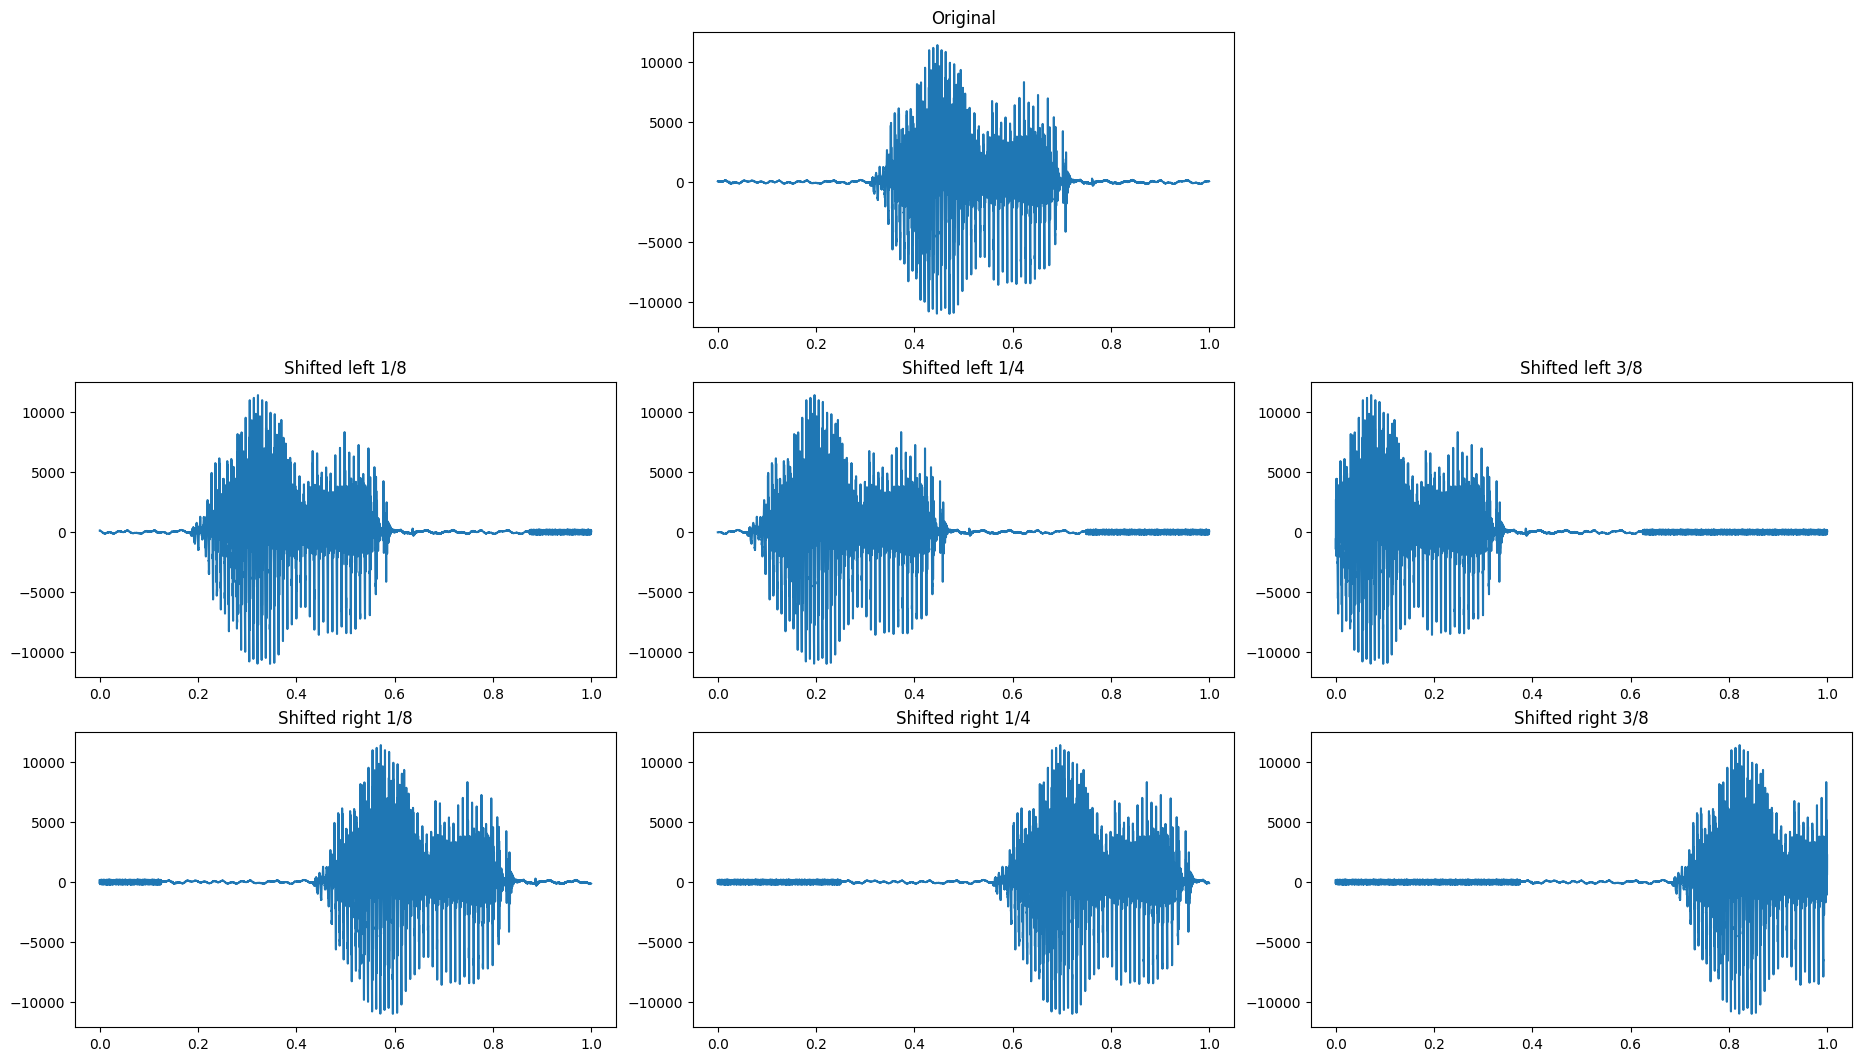

In [87]:
#commented out is for half second shift if desired

fig = plt.figure(constrained_layout=True)
axs = fig.add_gridspec(3, 3)

f_ax0 = fig.add_subplot(axs[0, 1])
f_ax1 = fig.add_subplot(axs[1, 0])
f_ax2 = fig.add_subplot(axs[1, 1])
f_ax3 = fig.add_subplot(axs[1, 2])
# f_ax4 = fig.add_subplot(axs[2, 3])
f_ax6 = fig.add_subplot(axs[2, 0])
f_ax7 = fig.add_subplot(axs[2, 1])
f_ax8 = fig.add_subplot(axs[2, 2])
# f_ax9 = fig.add_subplot(axs[3, 3])

f_ax0.plot(np.arange(1*fs)/fs, audio_dict[0])
f_ax1.plot(np.arange(1*fs)/fs, audio_dict[1])
f_ax2.plot(np.arange(1*fs)/fs, audio_dict[2])
f_ax3.plot(np.arange(1*fs)/fs, audio_dict[3])
# f_ax4.plot(np.arange(1*fs)/fs, audio_dict[4])
f_ax6.plot(np.arange(1*fs)/fs, audio_dict[6])
f_ax7.plot(np.arange(1*fs)/fs, audio_dict[7])
f_ax8.plot(np.arange(1*fs)/fs, audio_dict[8])
# f_ax9.plot(np.arange(1*fs)/fs, audio_dict[9])

f_ax0.set_title('Original')
f_ax1.set_title('Shifted left 1/8')
f_ax2.set_title('Shifted left 1/4')
f_ax3.set_title('Shifted left 3/8')
# f_ax4.set_title('Shifted left 1/2')
f_ax6.set_title('Shifted right 1/8')
f_ax7.set_title('Shifted right 1/4')
f_ax8.set_title('Shifted right 3/8')
# f_ax9.set_title('Shifted right 1/2')
fig.set_size_inches(18.5, 10.5, forward=True)
pass

#### Listen to time shifted Audio

In [88]:
from IPython.display import Audio 
from IPython.display import display

print("Original:")
display(Audio(audio_dict[0], rate=fs))
print("Shifted left 1/8:")
display(Audio(audio_dict[1], rate=fs))
print("Shifted left 1/4:")
display(Audio(audio_dict[2], rate=fs))
print("Shifted left 3/8:")
display(Audio(audio_dict[3], rate=fs))
# print("Shifted left 1/2:")
# display(Audio(audio_dict[4], rate=fs))
print("Shifted right 1/8:")
display(Audio(audio_dict[6], rate=fs))
print("Shifted right 1/4:")
display(Audio(audio_dict[7], rate=fs))
print("Shifted right 3/8:")
display(Audio(audio_dict[8], rate=fs))
# print("Shifted right 1/2:")
# display(Audio(audio_dict[9], rate=fs))

Original:


Shifted left 1/8:


Shifted left 1/4:


Shifted left 3/8:


Shifted right 1/8:


Shifted right 1/4:


Shifted right 3/8:


# Audio Augmentation- Pitch Shift
    * This will create copies of sample audio and pitch shift them
    * The variable *pitch_shift* allows control over pitch
    * The variable *desired_number_of_files* allows control of exactly how many samples to create
    * The loop will continue creating copies until desired count is reached, including pitch shifting already pitch shifted copies

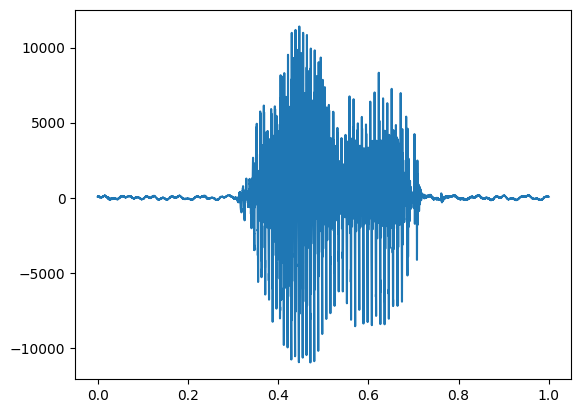

In [89]:
#Need to update filenames
data_dir = dir
filenames = tf.io.gfile.glob(str(data_dir) + '/*.wav')
#Testing if audio data imported correctly
filenames[0]
test_wav=filenames[0]
fs, test_wav = wavfile.read(test_wav)
plt.plot(np.arange(1*fs)/fs, test_wav)
plt.show()
ipd.Audio(test_wav, rate=fs)

In [54]:
print("The current number of files in directory is", len(filenames))

The current number of files in directory is 23478


#### Set Augment count

In [90]:
#How many of the files do you want to have total?
desired_number_of_files=100

#How do you want to pitch shift
    #positive=high pitch, negative = low pitch
    #0.25 is a good value
pitch_shift=0.25

### Doubling Equation:   
> $output=input * 2^{x}$

*Here $x$ is the number of times input is doubled

#### To get desired number of output files from input when loop doubles input every iteration of the for loop we solve for $x$:
   
> $x=\log _{2}(\frac{out}{in})$\
  $x=\frac{\ln (\frac{out}{in})} {\ln (2)}$
                 
#### Next $math.ceil()$ is used to round up to integer for loop iteration

> $x=$ math.ceil$(\frac{\ln (out)}{\ln (in)})$

In [91]:
#Doubling formula used to find range for outer for loop indexing with "i"
outer_range= math.ceil((np.log(desired_number_of_files / len(filenames)) / np.log(2) ))
outer_range

-5

#### Pitch Augmentation

In [92]:
#replace line 11 with comment below if you want to create a custom # < len(filenames)...
#                                                    ...comment out if statements and speed will improve significantly
#for index in range(40000): 

pitch_dict={}
for i in range(outer_range):
    for index in range(len(filenames)):
        test_wav=filenames[index]
        fs, test_wav = wavfile.read(test_wav)
        if i==0:
            pitch_dict[i]=test_wav
        test_wav_float=test_wav.astype(float)
        test_wav_pitch_shifted = librosa.effects.pitch_shift(test_wav_float, sr=sample_rate, n_steps=pitch_shift*(i+1))
        test_wav_pitch_shifted_int=test_wav_pitch_shifted.astype(np.int16)
        current_name = str(keyword_directory)+str(keyword) +f"_Pitch_Shift_{i}_{index}.wav"    
        write(current_name, fsamp, test_wav_pitch_shifted_int)

        files_in_folder=len(tf.io.gfile.glob(str(data_dir) + '/*.wav'))
        pitch_dict[i+1]=test_wav_pitch_shifted_int
        if (files_in_folder >= desired_number_of_files):
            break 
    filenames = tf.io.gfile.glob(str(data_dir) + '/*.wav')
    #update filenames with newly created files    
    if (files_in_folder >= desired_number_of_files):
        break 
print("Congratulations, the current number of files in directory is", len(filenames))

Congratulations, the current number of files in directory is 4719


#### Plot Pitch Shift

KeyError: 0

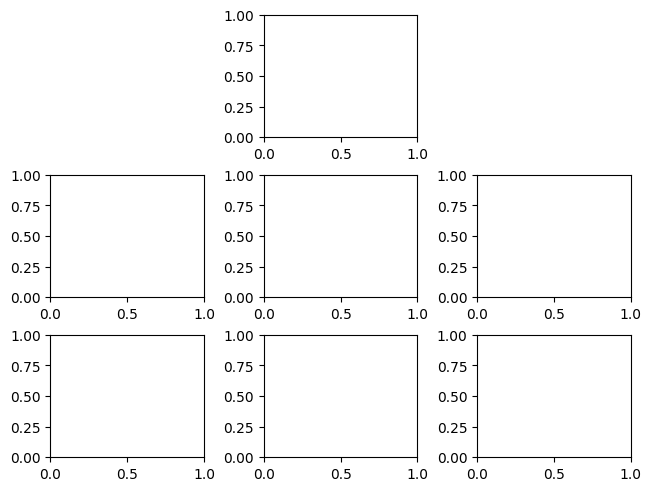

In [93]:
fig = plt.figure(constrained_layout=True)
axs = fig.add_gridspec(3, 3)

f_ax0 = fig.add_subplot(axs[0, 1])
f_ax1 = fig.add_subplot(axs[1, 0])
f_ax2 = fig.add_subplot(axs[1, 1])
f_ax3 = fig.add_subplot(axs[1, 2])
f_ax4 = fig.add_subplot(axs[2, 0])
f_ax5 = fig.add_subplot(axs[2, 1])
f_ax6 = fig.add_subplot(axs[2, 2])

f_ax0.plot(np.arange(1*fs)/fs, pitch_dict[0])
f_ax0.set_title('Original')

if outer_range>1:
    f_ax1.plot(np.arange(1*fs)/fs, pitch_dict[1])
    f_ax1.set_title('Pitch Shift lvl 1')
if outer_range>2:
    f_ax2.plot(np.arange(1*fs)/fs, pitch_dict[2])
    f_ax2.set_title('Pitch Shift lvl 2')
if outer_range>3:
    f_ax3.plot(np.arange(1*fs)/fs, pitch_dict[3])
    f_ax3.set_title('Pitch Shift lvl 3')
if outer_range>4:
    f_ax4.plot(np.arange(1*fs)/fs, pitch_dict[4])
    f_ax4.set_title('Pitch Shift lvl 4')
if outer_range>5:
    f_ax5.plot(np.arange(1*fs)/fs, pitch_dict[5])
    f_ax5.set_title('Pitch Shift lvl 5')
if outer_range>6:
    f_ax6.plot(np.arange(1*fs)/fs, pitch_dict[6])
    f_ax6.set_title('Pitch Shift lvl 6')

fig.set_size_inches(18.5, 10.5, forward=True)
pass

#### Listen to Pitch Shift

In [94]:
from IPython.display import Audio 
from IPython.display import display

print("Original:")
display(Audio(pitch_dict[0], rate=fs))

if outer_range>1:
    print("Pitch Shift lvl 1")
    display(Audio(pitch_dict[1], rate=fs))
if outer_range>2:
    print("Pitch Shift lvl 2")
    display(Audio(pitch_dict[2], rate=fs))
if outer_range>3:
    print("Pitch Shift lvl 3")
    display(Audio(pitch_dict[3], rate=fs))
if outer_range>4:
    print("Pitch Shift lvl 4")
    display(Audio(pitch_dict[3], rate=fs))
if outer_range>5:
    print("Pitch Shift lvl 5")
    display(Audio(pitch_dict[4], rate=fs))
if outer_range>6:
    print("Pitch Shift lvl 6")
    display(Audio(pitch_dict[5], rate=fs))

Original:


KeyError: 0

# Write augmented data files to testing and validation .txt file 

In [95]:
#Need to update filenames
data_dir = dir
filenames = tf.io.gfile.glob(str(data_dir) + '/*.wav')

In [96]:
#Verifying opens files correctly
filenames[0]

'c:\\Users\\Matt\\OneDrive\\Documents\\Github\\Github-IOT-Project-2\\training\\preprocessing\\Augmented_internet\\internet_222119.wav'

In [97]:
num_files=len(filenames)
num_files
print("Total files:", num_files)

Total files: 4719


In [98]:
#randomizes order of samples for validation list
random_list = list(range(0, num_files)) #create array [1,2,3...]
random.shuffle(random_list) #randomize the array

In [99]:
#will write to file in form: keyword_folder/audio_sample
from pathlib import Path

#Set directory for validation list
dir_path = Path(os.getcwd()) #current directory

file_name = 'validation_list.txt'

#How many files to add to document?
add_val_num=5

# check if directory exists
#copys over files to the validation document
if dir_path.is_dir():
    f = open (dir_path.joinpath(file_name),'a')
    filenames = tf.io.gfile.glob(str(data_dir) + '/*.wav')
    for i in range(add_val_num):
        f.write('\n'+keyword+'\\'+ os.path.basename(filenames[random_list[i]]))
    f.close()
    print(add_val_num, keyword, "samples added to", file_name)
else:
    print('Directory doesnt exist')

5 internet samples added to validation_list.txt


# Additional Augmentations
    *These change volume
    *Still needs work, suggest staying with previous augmentations

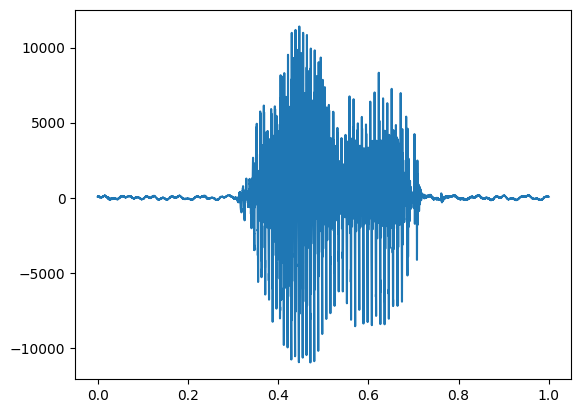

In [100]:
#load data
data_dir = dir
filenames = tf.io.gfile.glob(str(data_dir) + '/*.wav')
#Testing if audio data imported correctly
test_wav=filenames[0]
fs, test_wav = wavfile.read(test_wav)
plt.plot(np.arange(1*fs)/fs, test_wav)
plt.show()
ipd.Audio(test_wav, rate=fs)

In [101]:
print("Sample count:", len(filenames))

Sample count: 4719


#### Icrease audio sample amplitude by multiplier

In [102]:
#Increases existing audios volume/amplitue 
multiplier=3
for i in range(1,multiplier):
    for index in range(len(filenames)):
            test_wav=filenames[index]
            fs, test_wav = wavfile.read(test_wav)
            sound=test_wav*(i)
            sound_normalized=sound.astype(np.int16)
            current_name = str(keyword_directory) + str(keyword)+f"noiseLVL_{i}_{index}.wav" 
            write(current_name, fsamp, sound_normalized)

data_dir = dir
filenames = tf.io.gfile.glob(str(data_dir) + '/*.wav')
print("Multiplier complete")
print("Sample count:", len(filenames))

Multiplier complete
Sample count: 14157


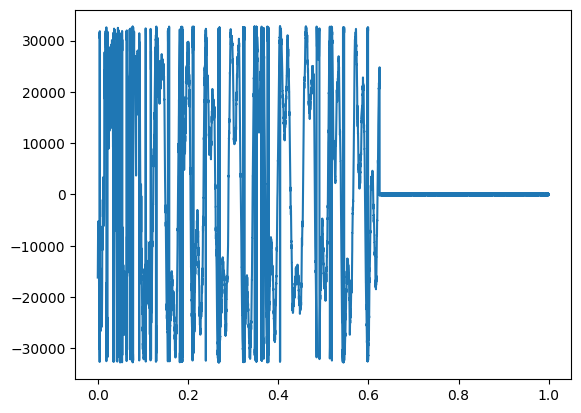

In [103]:
test_wav=filenames[250]
fs, test_wav = wavfile.read(test_wav)
plt.plot(np.arange(1*fs)/fs, test_wav)
plt.show()
ipd.Audio(test_wav, rate=fs)

#### Normalize to specific amplitude level

In [104]:
noise_level=12000
for index in range(len(filenames)):
        test_wav=filenames[index]
        fs, test_wav = wavfile.read(test_wav)
        sound = test_wav*(noise_level/max(test_wav))
        sound_normalized=sound.astype(np.int16)
        current_name = str(keyword_directory) + str(keyword)+f"_{index}.wav" 
        #current_name = filenames[index]
        write(current_name, fsamp, sound_normalized)
        if ((index%10)==0):
            print(f"{index}/{len(filenames)} complete")

0/14157 complete
10/14157 complete
20/14157 complete
30/14157 complete
40/14157 complete
50/14157 complete
60/14157 complete
70/14157 complete
80/14157 complete
90/14157 complete
100/14157 complete
110/14157 complete
120/14157 complete
130/14157 complete
140/14157 complete
150/14157 complete
160/14157 complete
170/14157 complete
180/14157 complete
190/14157 complete
200/14157 complete
210/14157 complete
220/14157 complete
230/14157 complete
240/14157 complete
250/14157 complete
260/14157 complete
270/14157 complete
280/14157 complete
290/14157 complete
300/14157 complete
310/14157 complete
320/14157 complete
330/14157 complete
340/14157 complete
350/14157 complete
360/14157 complete
370/14157 complete
380/14157 complete
390/14157 complete
400/14157 complete
410/14157 complete
420/14157 complete
430/14157 complete
440/14157 complete
450/14157 complete
460/14157 complete
470/14157 complete
480/14157 complete
490/14157 complete
500/14157 complete
510/14157 complete
520/14157 complete
530/

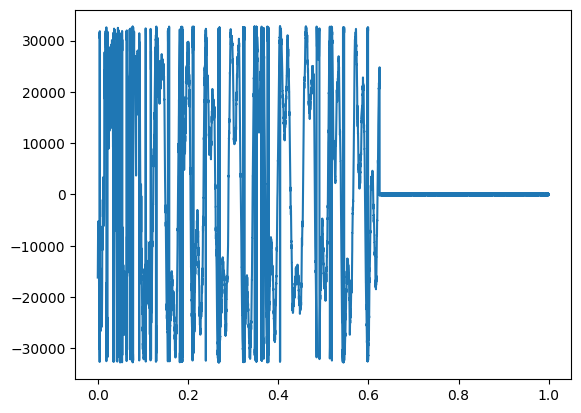

In [105]:
test_wav=filenames[250]
fs, test_wav = wavfile.read(test_wav)
plt.plot(np.arange(1*fs)/fs, test_wav)
plt.show()
ipd.Audio(test_wav, rate=fs)